# Gram Matrices for Style (Neural Style Transfer) — Visual Demo

This notebook builds the **first part** of the larger demo:
**Load 4 images → run a fixed pretrained CNN → compute Gram matrices at selected layers → sanity-check everything.**

Planned later (not yet in this part):
- Pairwise similarity (cosine / L2) on style embeddings
- PCA “downsampling” of Gram matrices for visualization
- A distance heatmap across images

---

## What you provide
Set the 4 URLs in the next cell:
- 2 images from “Style A” (e.g., Van Gogh)
- 2 images from “Style B” (e.g., animation / Disney-like)

**Tip:** Keep images reasonably sized (≤ 2000px wide). We'll resize anyway.


In [6]:
# -------------------------
# Required utility: load_image(url)
from io import BytesIO
import requests
from PIL import Image

def load_image(url):
    '''Downloads and returns a PIL image from the given URL.'''
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise ValueError(f"Failed to download image: {url}")
    try:
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        raise ValueError(f"Could not open image from {url}. Error: {e}")
# -------------------------

# Sanity
assert callable(load_image)


In [21]:
# Provide your 4 image URLs here
URLS = {
    "vangogh_1": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/960px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg",
    "vangogh_2": "https://cdn.kastatic.org/ka-perseus-images/653f09fedc305ad96ff0f7272df19fa7624f3c7e.jpg",
    "disney_1":  "https://assets.teenvogue.com/photos/5ce81c56b68fa25979a033a9/16:9/w_1280,c_limit/Aladdin-Featured-11182017.jpg",
    # "disney_2":  "https://www.hollywoodreporter.com/wp-content/uploads/2018/07/aladdin_still.jpg?w=1296&h=730&crop=1",
    "disney_2":  "https://d23.com/app/uploads/2015/10/1180w-600h_aladdin-diamond-edition-1180x600.jpg",
}

# Sanity
assert isinstance(URLS, dict) and len(URLS) == 4
for k, v in URLS.items():
    assert isinstance(k, str) and isinstance(v, str)


In [22]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torchvision.models import vgg19, VGG19_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# Sanity
assert device in ("cuda", "cpu")


device: cpu


In [23]:
def assert_tensor(t: torch.Tensor, *, shape=None, finite=True, name="tensor"):
    assert isinstance(t, torch.Tensor), f"{name} is not a torch.Tensor"
    if shape is not None:
        assert tuple(t.shape) == tuple(shape), f"{name}.shape={tuple(t.shape)} expected={tuple(shape)}"
    if finite:
        assert torch.isfinite(t).all().item(), f"{name} contains non-finite values"

def assert_symmetric_psd(G: torch.Tensor, *, tol_sym=1e-5, tol_eig=1e-6, name="G"):
    """For a true Gram matrix: symmetric, PSD. Small negative eigenvalues may occur due to float error."""
    assert_tensor(G, name=name)
    assert G.ndim == 2 and G.shape[0] == G.shape[1], f"{name} must be square"
    sym_err = (G - G.T).abs().max().item()
    assert sym_err < tol_sym, f"{name} not symmetric enough: max|G-G^T|={sym_err}"
    Gcpu = G.detach().cpu()
    eigvals = torch.linalg.eigvalsh(Gcpu)
    min_eig = eigvals.min().item()
    assert min_eig >= -tol_eig, f"{name} not PSD within tolerance: min_eig={min_eig}"
    assert (torch.diag(Gcpu) >= -tol_eig).all().item(), f"{name} has negative diagonal entries"

tmp = torch.eye(4)
assert_symmetric_psd(tmp, name="I4")


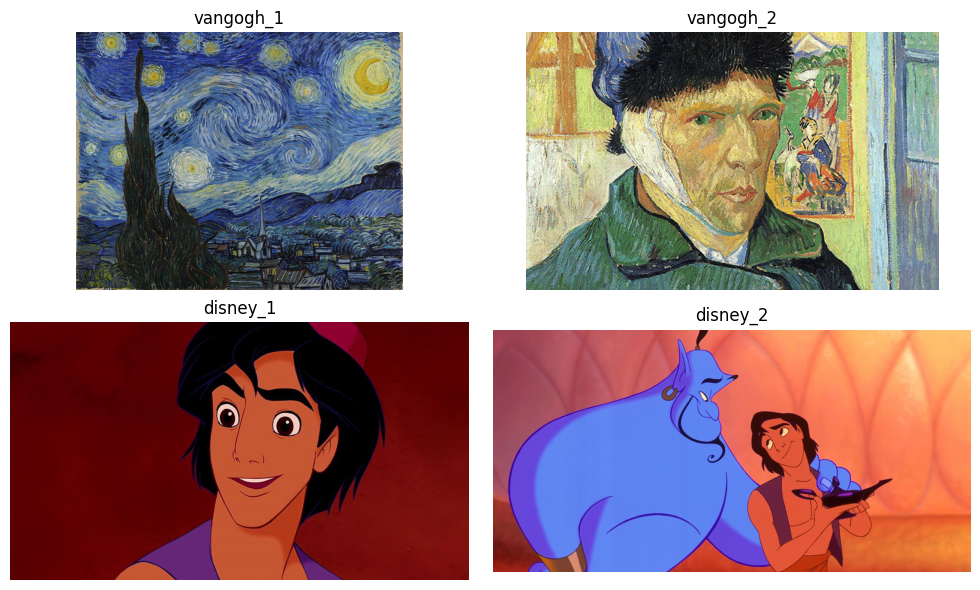

In [24]:
# Load the 4 images
imgs_pil = {k: load_image(u) for k, u in URLS.items()}

# Show them
plt.figure(figsize=(10, 6))
for i, (k, im) in enumerate(imgs_pil.items(), start=1):
    plt.subplot(2, 2, i)
    plt.imshow(im)
    plt.title(k)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Sanity
assert len(imgs_pil) == 4
for k, im in imgs_pil.items():
    assert hasattr(im, "size")
    w, h = im.size
    assert w > 10 and h > 10


## Fixed pretrained model

We use a fixed pretrained **VGG-19** (features only).
No training. No finetuning. We compute feature maps and Gram matrices.


In [25]:
weights = VGG19_Weights.DEFAULT
vgg = vgg19(weights=weights).features.to(device).eval()
for p in vgg.parameters():
    p.requires_grad_(False)

IMG_SIZE = 256
preprocess = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])

# Sanity
assert isinstance(vgg, nn.Module)


## Choose layers for "style"

We pick layer indices from `vgg.features` corresponding to ReLU outputs.
We verify shapes rather than rely on layer-name assumptions.


In [26]:
LAYER_IDS = [1, 6, 11, 20]

# Sanity
assert all(isinstance(i, int) for i in LAYER_IDS)
assert len(set(LAYER_IDS)) == len(LAYER_IDS)


In [27]:
def pil_to_tensor(im_pil):
    x = preprocess(im_pil).unsqueeze(0)  # (1,3,H,W)
    return x.to(device)

def extract_features(x: torch.Tensor, layer_ids=LAYER_IDS):
    feats = {}
    h = x
    for i, layer in enumerate(vgg):
        h = layer(h)
        if i in layer_ids:
            feats[i] = h
    return feats

features = {}
for name, im in imgs_pil.items():
    x = pil_to_tensor(im)
    feats = extract_features(x)
    features[name] = feats

# Sanity
for name in features:
    feats = features[name]
    assert set(feats.keys()) == set(LAYER_IDS), f"{name} missing layers"
    for lid, act in feats.items():
        assert act.ndim == 4 and act.shape[0] == 1, f"{name} layer {lid} bad shape {tuple(act.shape)}"
        assert_tensor(act, name=f"act[{name}][{lid}]")


## Gram matrix

For a feature map $A \in \mathbb{R}^{1 \times C \times H \times W}$:

1. Flatten spatial dims: $F \in \mathbb{R}^{C \times N}$, where $N = HW$
2. Gram: $G = FF^T \in \mathbb{R}^{C \times C}$

We normalize by **(C·H·W)** so layers don't dominate only due to size.


In [28]:
def gram_matrix(act: torch.Tensor, normalize=True) -> torch.Tensor:
    assert act.ndim == 4 and act.shape[0] == 1
    _, C, H, W = act.shape
    F = act[0].reshape(C, H * W)   # (C, N)
    G = F @ F.t()                 # (C, C)
    if normalize:
        G = G / (C * H * W)
    return G

grams = {}
for name in features:
    grams[name] = {}
    for lid, act in features[name].items():
        G = gram_matrix(act, normalize=True).detach().cpu()
        grams[name][lid] = G

# Sanity
for name in grams:
    for lid, G in grams[name].items():
        assert_symmetric_psd(G, name=f"G[{name}][{lid}]")


## Visual sanity check (small layer)

Gram matrices get huge in deeper layers.
We visualize an early layer where the heatmap is readable.


Visualizing layer 1 with C = 64


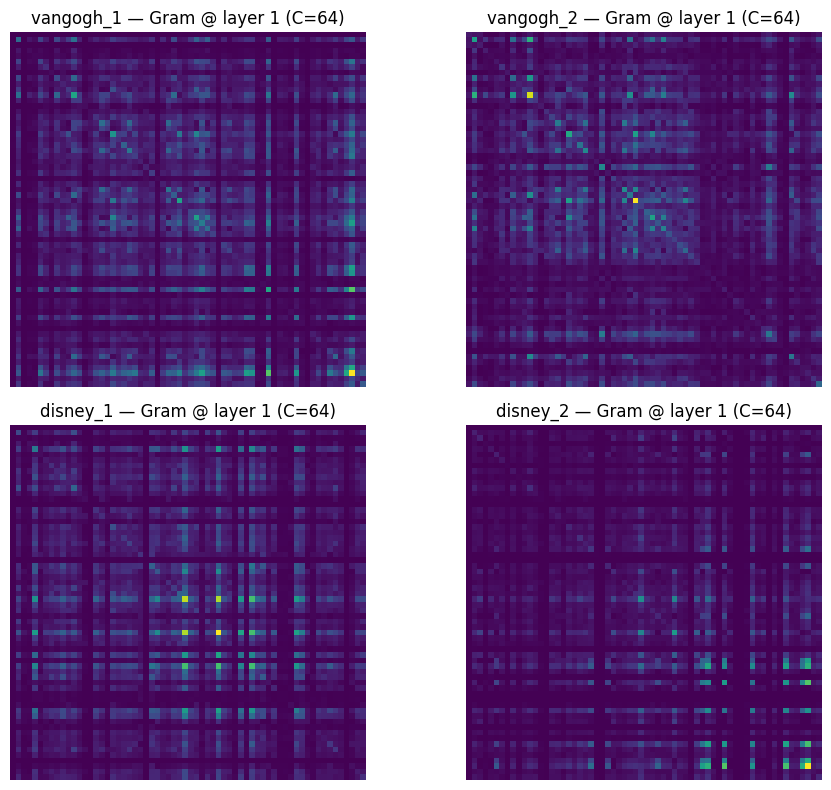

In [29]:
viz_lid = LAYER_IDS[0]
C = next(iter(grams.values()))[viz_lid].shape[0]
print("Visualizing layer", viz_lid, "with C =", C)
assert C <= 128, "Pick an early layer with <=128 channels for readability."

plt.figure(figsize=(10, 8))
for i, (name, d) in enumerate(grams.items(), start=1):
    G = d[viz_lid].numpy()
    plt.subplot(2, 2, i)
    plt.imshow(G)
    plt.title(f"{name} — Gram @ layer {viz_lid} (C={G.shape[0]})")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Note (for later): explicit layer weights

Two separate choices:

1. **Gram normalization** by size (we already do this): divides by $C \cdot H \cdot W$.
   This is about fair scaling and stable gradients.

2. **Layer weights** $w_\ell$ in the final style loss:
$\mathcal{L}_{style} = \sum_\ell w_\ell \|G_\ell^{gen} - G_\ell^{style}\|^2$

Where do $w_\ell$ come from?
- Many references use **uniform** weights (all 1’s).
- Others hand-tune weights to emphasize fine texture (early layers) vs larger motifs (mid layers).
- For teaching: treat weights as a **preference knob**, not a constant derived from theory.

We'll keep it simple later (uniform weights), and optionally add an interactive slider to explore the effect.


In [30]:
# End-of-part checkpoint: what we have so far

print("Images:", list(imgs_pil.keys()))
print("Layers:", LAYER_IDS)
for name in grams:
    for lid in LAYER_IDS:
        G = grams[name][lid]
        print(f"{name:10s} layer {lid:2d} Gram shape:", tuple(G.shape))

# Sanity: all PSD
assert len(grams) == 4
for name in grams:
    assert set(grams[name].keys()) == set(LAYER_IDS)
    for lid in LAYER_IDS:
        assert_symmetric_psd(grams[name][lid], name=f"G[{name}][{lid}]")

print("\n✅ Part 1 complete: Gram matrices computed and sanity-checked.")


Images: ['vangogh_1', 'vangogh_2', 'disney_1', 'disney_2']
Layers: [1, 6, 11, 20]
vangogh_1  layer  1 Gram shape: (64, 64)
vangogh_1  layer  6 Gram shape: (128, 128)
vangogh_1  layer 11 Gram shape: (256, 256)
vangogh_1  layer 20 Gram shape: (512, 512)
vangogh_2  layer  1 Gram shape: (64, 64)
vangogh_2  layer  6 Gram shape: (128, 128)
vangogh_2  layer 11 Gram shape: (256, 256)
vangogh_2  layer 20 Gram shape: (512, 512)
disney_1   layer  1 Gram shape: (64, 64)
disney_1   layer  6 Gram shape: (128, 128)
disney_1   layer 11 Gram shape: (256, 256)
disney_1   layer 20 Gram shape: (512, 512)
disney_2   layer  1 Gram shape: (64, 64)
disney_2   layer  6 Gram shape: (128, 128)
disney_2   layer 11 Gram shape: (256, 256)
disney_2   layer 20 Gram shape: (512, 512)

✅ Part 1 complete: Gram matrices computed and sanity-checked.
